In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

import numpy as np
import math

Using TensorFlow backend.


In [2]:
PATH_TO_DF = "../data/output_convnet/VGG16"

img_width = 150
img_height = 150

n_epochs = 50
batch_size = 16

train_data_dir = "train"  
validation_data_dir = "validation"
test_data_dir = "test"

n_train_samples = 3000
n_validation_samples = 1000
n_test_samples = 1000
n_classes = 8

In [3]:
# https://b/log.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# saving bottleneck features
import time

ti_bn_features = time.time()

model = VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255)

'''
https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L1002
if PIL version 1.1.3 interpolation = 'lanczos'
else interpolation = 'bicubic' 
''' 
# train
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False,
    interpolation = 'lanczos')

# important step in order to get the exact number
max_queue_size_train = int(math.ceil(n_train_samples / batch_size))

bnfeatures_train = model.predict_generator(
    generator, max_queue_size_train)

np.save('../data/output_convnet/VGG16/VGG16_bnfeatures_train.npy', bnfeatures_train)

# validation
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    interpolation = 'lanczos')

max_queue_size_val = int(math.ceil(n_validation_samples / batch_size))


bnfeatures_val = model.predict_generator(  
     generator, max_queue_size_val)

np.save('../data/output_convnet/VGG16/VGG16_bnfeatures_val.npy', bnfeatures_val)


tf_bn_features = time.time()    
tt_bn_features = tf_bn_features - ti_bn_features

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


In [4]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_features)))

00:00:31


In [5]:
# training top layer
import os

ti_bn_train = time.time()

# we have to get the classes names so we build again a generator
datagen_top_layer = ImageDataGenerator(rescale=1./255)  

# train
generator_top_layer = datagen_top_layer.flow_from_directory(
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False,
    interpolation = 'lanczos')  

train_data = np.load('../data/output_convnet/VGG16/VGG16_bnfeatures_train.npy')

# ref attribute classes --> https://keras.io/preprocessing/image/
train_labels = generator_top_layer.classes # the key attribute
train_labels = to_categorical(train_labels, num_classes=n_classes) # the key function

# validation
generator_top_layer = datagen_top_layer.flow_from_directory(  
    validation_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False,
    interpolation = 'lanczos')  

# val_data = np.load('../data/output_convnet/VGG16/bnfeatures_val.npy')
val_data = np.load('../data/output_convnet/VGG16/VGG16_bnfeatures_val.npy') 

val_labels = generator_top_layer.classes # the key attribute
val_labels = to_categorical(val_labels, num_classes=n_classes) # the key function


# top model, could be with a diff dense, optimizer, momentum -> https://keras.io/optimizers/
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(n_classes, activation='softmax'))  


model.compile(optimizer=SGD(lr=0.001),
              loss='categorical_crossentropy', metrics=['accuracy']) 


historical_data = model.fit(train_data, train_labels,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(val_data, val_labels))  

# h5py
model.save_weights('../data/output_convnet/VGG16/VGG16_bn_model.h5')  

tf_bn_train = time.time()    
tt_bn_train = tf_bn_train - ti_bn_train

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 1s 440us/step - loss: 1.6519 - acc: 0.4117 - val_loss: 1.2709 - val_acc: 0.5930
Epoch 2/50
3000/3000 [==============================] - 1s 283us/step - loss: 1.2329 - acc: 0.5883 - val_loss: 1.0211 - val_acc: 0.7410
Epoch 3/50
3000/3000 [==============================] - 1s 283us/step - loss: 1.0600 - acc: 0.6470 - val_loss: 0.9011 - val_acc: 0.7620
Epoch 4/50
3000/3000 [==============================] - 1s 282us/step - loss: 0.9548 - acc: 0.6883 - val_loss: 0.8018 - val_acc: 0.7970
Epoch 5/50
3000/3000 [==============================] - 1s 309us/step - loss: 0.8869 - acc: 0.7067 - val_loss: 0.7437 - val_acc: 0.8070
Epoch 6/50
3000/3000 [==============================] - 1s 305us/step - loss: 0.8111 - acc: 0.7323 - val_loss: 0.7004 - val_acc: 0.8040
Epoch 7/50
3000/3000 [==============================

In [6]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_train)))

00:00:44


In [7]:
import h5py
hdf5_file = h5py.File('../data/output_convnet/VGG16/VGG16_bn_model.h5', mode='r')
print(list(hdf5_file))

['dense_1', 'dense_2', 'dropout_1', 'flatten_1']


In [8]:
(loss, acc) = model.evaluate(val_data, val_labels, batch_size=batch_size, verbose=0)
print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))  

acc: 86.50% - loss: 0.390120


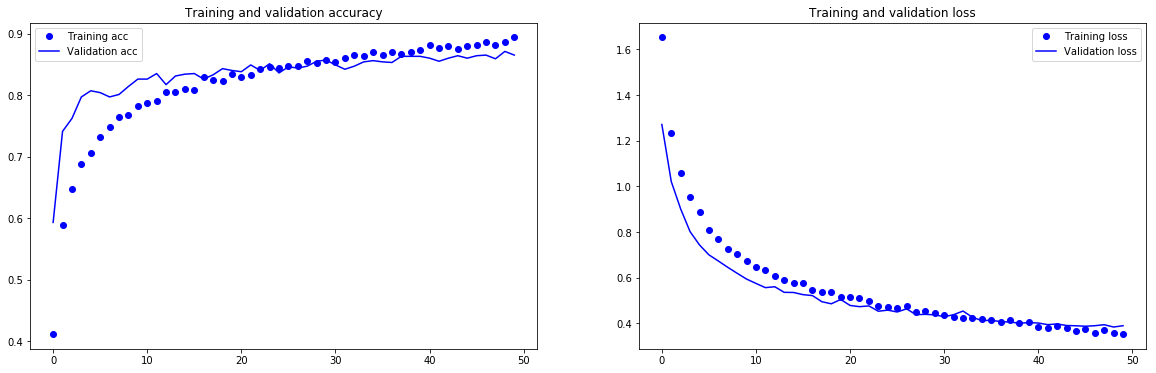

In [9]:
# historical_data.history acc and loss data over the epochs (train and validation)
import matplotlib.pyplot as plt

train_acc = historical_data.history['acc']
train_loss = historical_data.history['loss']

val_acc = historical_data.history['val_acc'] # validation
val_loss = historical_data.history['val_loss'] # validation

range_epochs = range(n_epochs)

fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plt.plot(range_epochs, train_acc, 'bo', label='Training acc')
plt.plot(range_epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1,2,2)
plt.plot(range_epochs, train_loss, 'bo', label='Training loss')
plt.plot(range_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig(os.path.join(PATH_TO_DF, "VGG16_bn_acc_loss.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb
plt.show()